In [4]:
%matplotlib inline

In [5]:
import xray 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [6]:
Dam_info = pd.read_csv('/raid/yifan/Reservoir_modeling/Run_reservoir/reservoir_to_model_maxFlowFromRVIC_exceed0.2.csv')

0
1
2
3
4
5
6
8
9
10
11
12
13
14
15
16
18
19
22


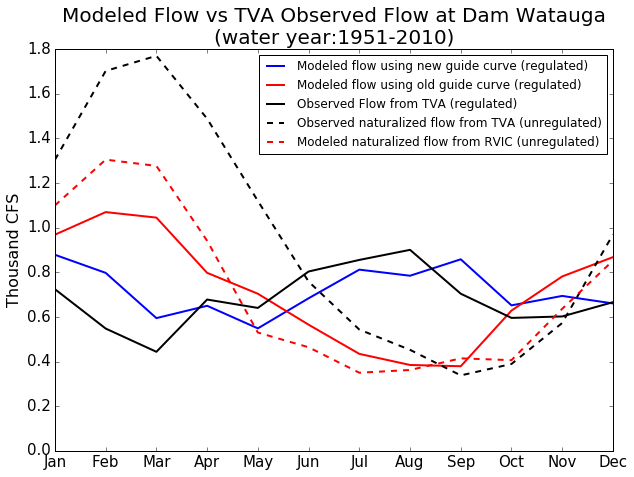

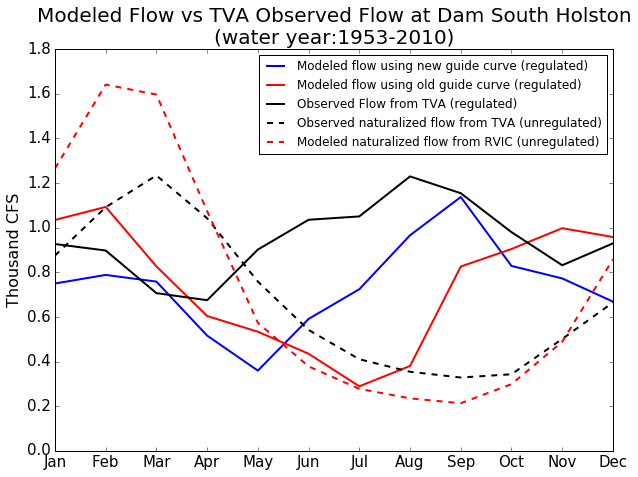

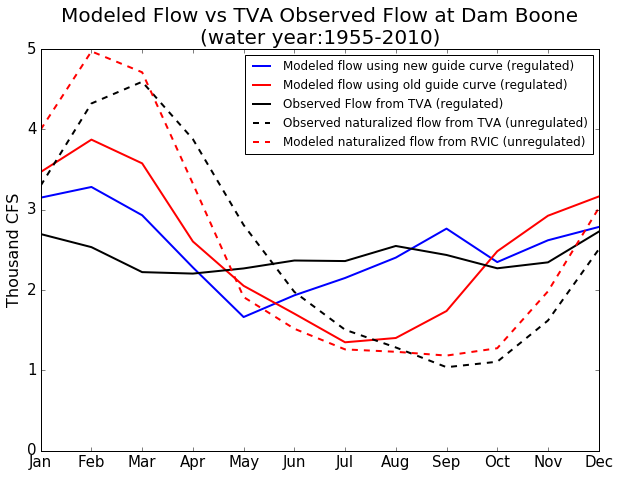

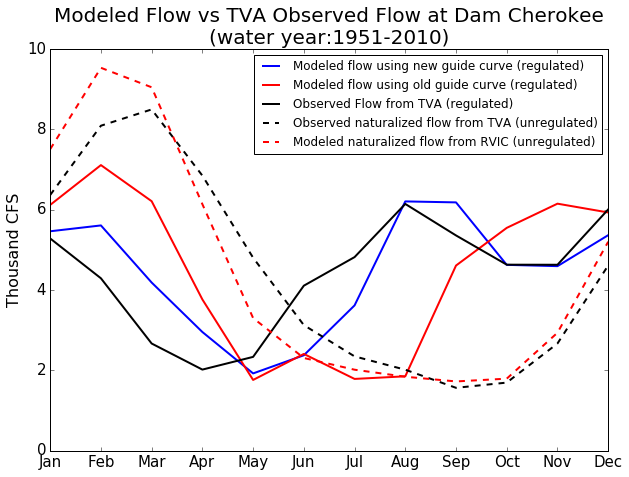

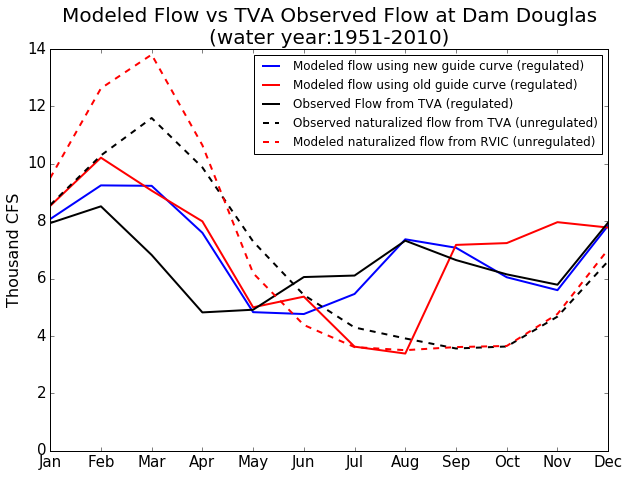

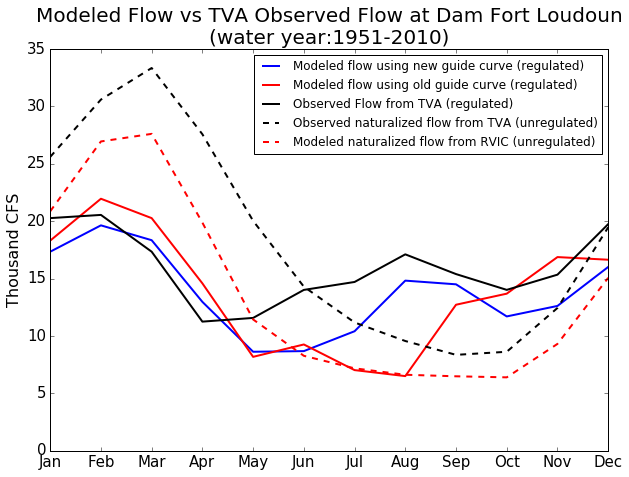

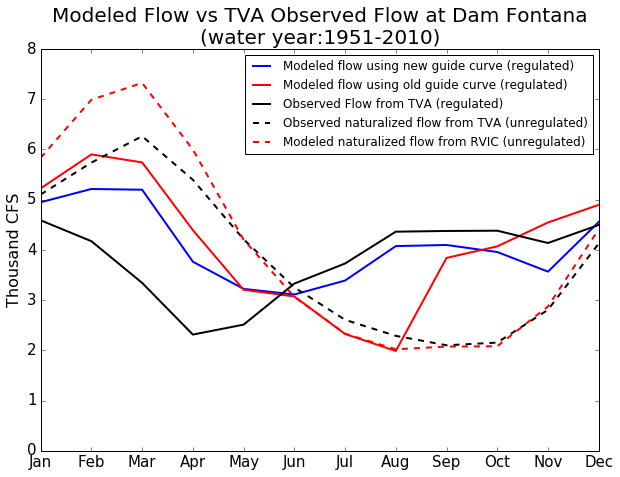

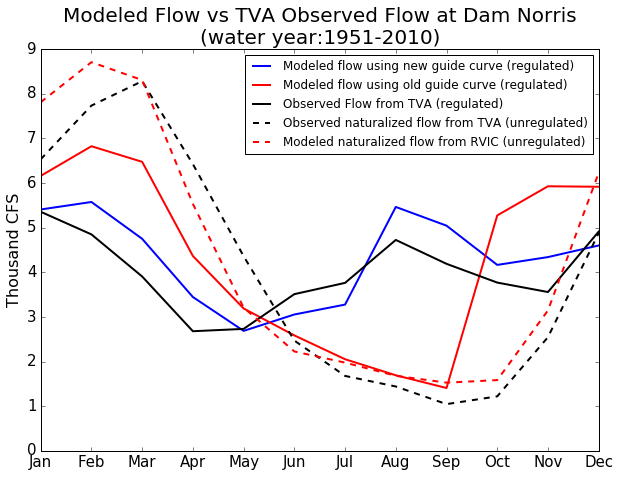

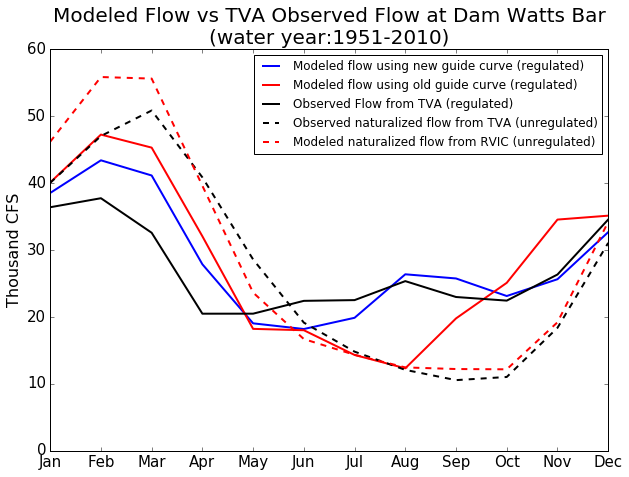

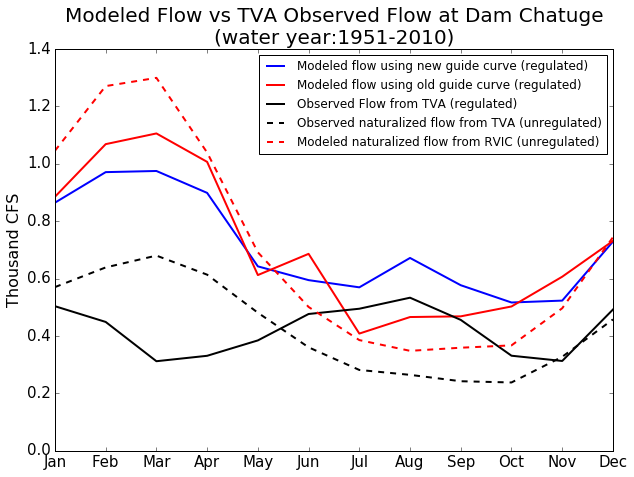

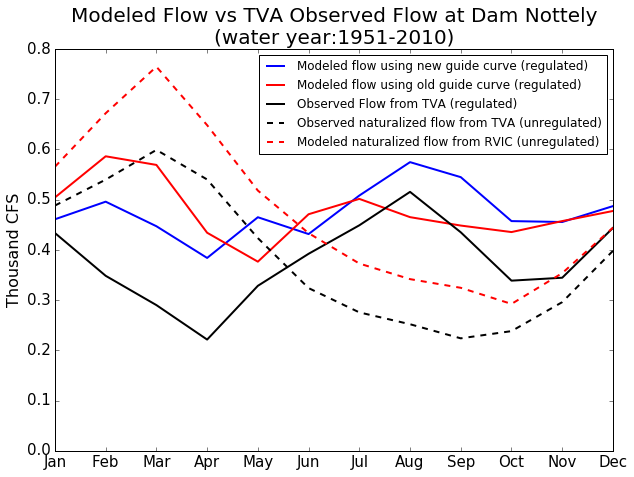

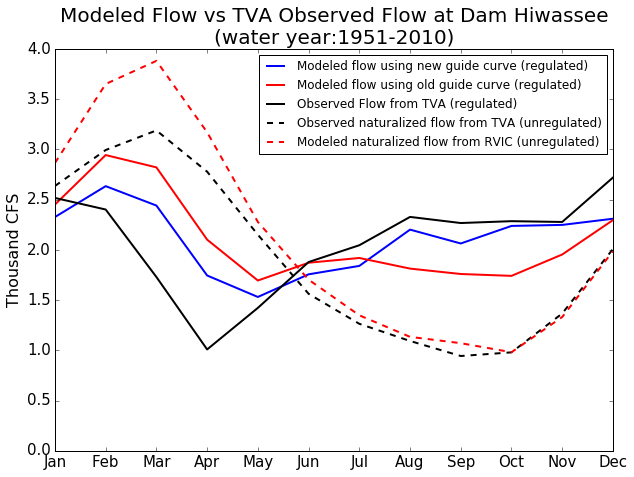

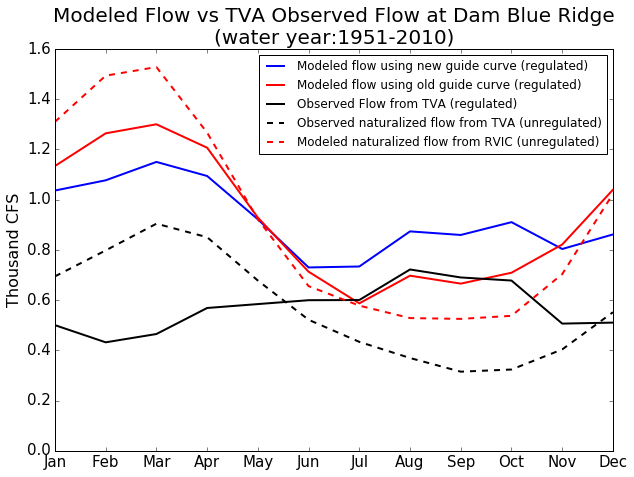

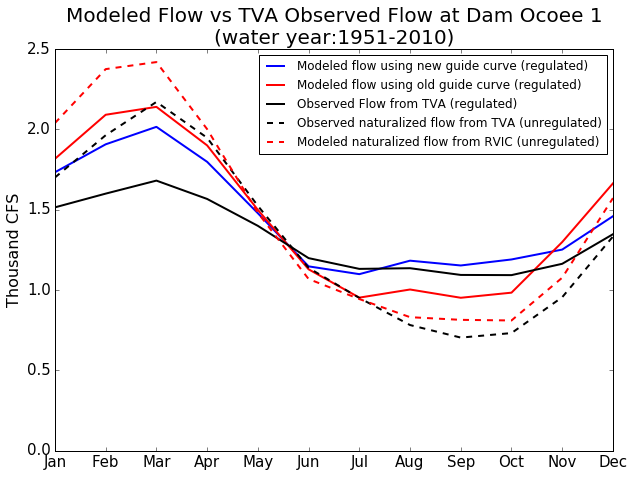

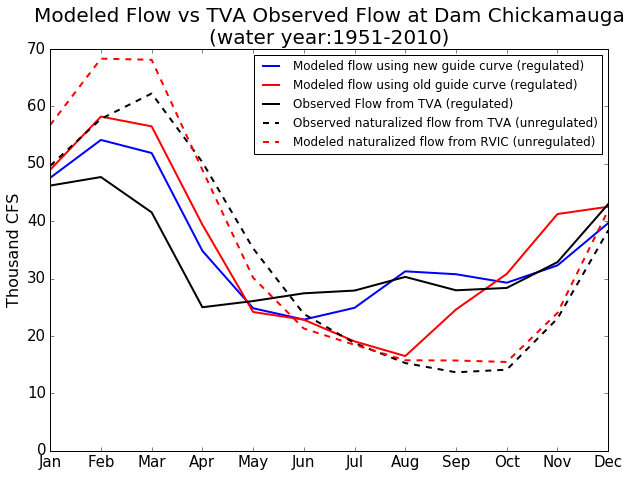

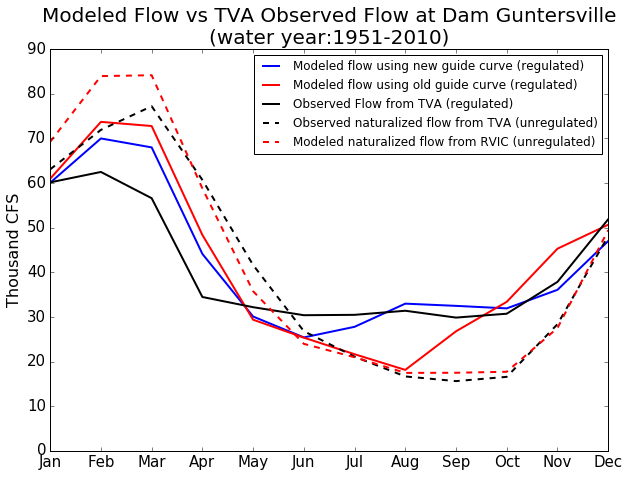

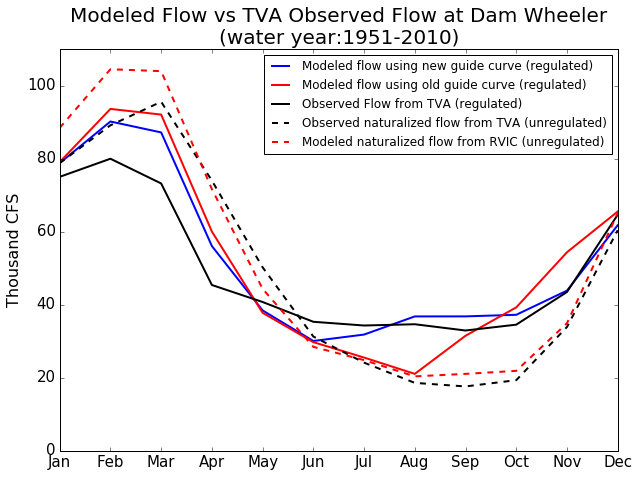

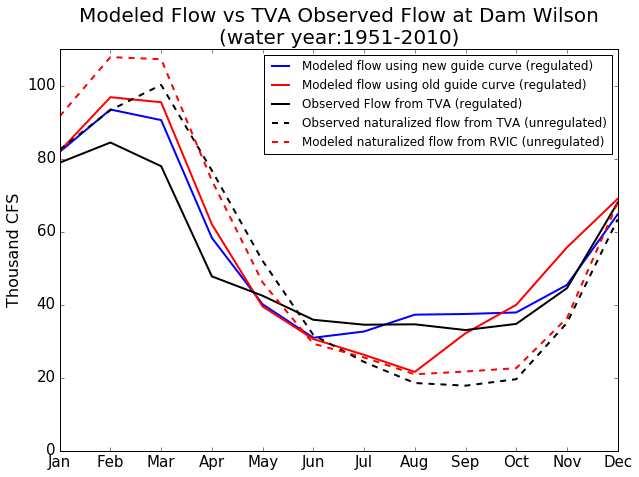

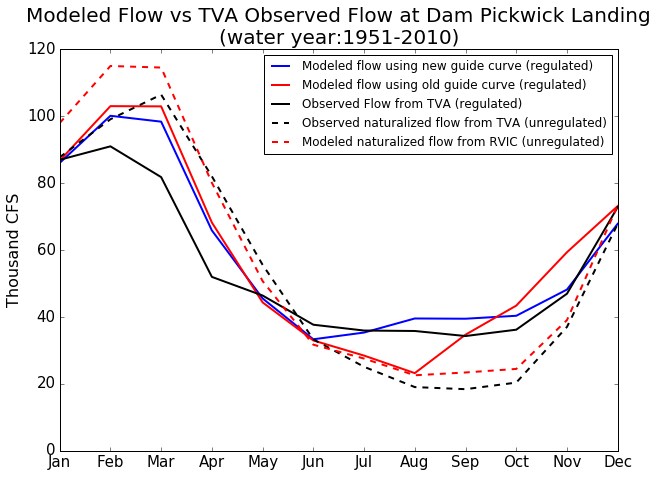

In [11]:
#for i in range(len(Dam_info['dam_name'])):
for i in [0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,18,19,22]:
#for i in [0]:    
    #Define the period
    starting_year = max(Dam_info['year_operated_start_of_Calendar_year'][i],1949)+1
    end_year = 2010
    starting_time = str(starting_year)+'-10-01 12:00:00' #This is the start of water year----starting_year+1
    end_time = str(end_year)+'-09-30 12:00:00'
    starting_date = str(starting_year)+'-10-01 00:00:00' #This is the start of water year----starting_year+1
    end_date = str(end_year)+'-09-30 00:00:00'
    time_index = pd.date_range(start = starting_time,end = end_time ,freq='D')
    
    #read in TVA observed streamflow (regulated)
    xls_path = '/raid/yifan/Reservoir_modeling/TVA_reservoir_data/'+Dam_info['xls_name'][i]+'.xlsx'
    Raw = pd.ExcelFile(xls_path)
    Total_Q = Raw.parse(sheetname='TotalQ')
    if Dam_info['year_operated_start_of_Calendar_year'][i] <= 1949:
        col_del = np.concatenate([np.arange(0,starting_year-Dam_info['year_operated_start_of_Calendar_year'][4],1),np.arange(-1,end_year-2015-1,-1)])
    else:
        col_del = np.arange(-1,end_year-2015-1,-1)    
    Observed_Q = pd.concat([Total_Q.ix[1:60],Total_Q.ix[62:366]]).dropna(axis=1)
    Observed_Q = Observed_Q.groupby(Observed_Q.index.map(lambda t: t.month)).mean()
    M = Observed_Q.drop(Observed_Q.columns[col_del],axis=1)
    M.iloc[0:10,0]=np.nan
    M.iloc[10:12,M.shape[1]-1]=np.nan
    
    #read in modeled streamflow using new guide curve -- median of daily data (regulated)
    Raw_model = xray.open_dataset('/raid/yifan/Reservoir_modeling/Run_reservoir/result_new_guide_curve.modified_flow.nc')
    
    #read in observed stream flow from TVA(unregulated)
    filename_latlon = str(Dam_info['grid_lat'][i])+'_'+str(Dam_info['grid_lon'][i])+'.daily.1903_2013'
    dir_latlon = '/raid2/ymao/VIC_RBM_east_RIPS/data/TVA_data/naturalized_flow/downscaled_daily_flow/latlon/'+filename_latlon
    Nflow_TVA = pd.read_csv(dir_latlon,sep=' ',header=None,parse_dates=[[0,1,2]])
    Nflow_TVA.rename(columns={'0_1_2': 'Time', 3: 'flow(cfs)'}, inplace=True)
    Nflow_TVA = Nflow_TVA.set_index('Time')
    Nflow_TVA = Nflow_TVA.ix[starting_date:end_date]
    Natual_flow_TVA = Nflow_TVA['flow(cfs)'].groupby(Nflow_TVA.index.map(lambda t: t.month)).mean()
    
    #read in modeled streamflow from RVIC (unregulated)
    RVIC = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/RVIC/Tennessee_8th_grid/hist/Tennessee_UH_1.hist_1949_2010.calibrated_1961_1970.rvic.h0a.2011-01-01.nc')
    RVIC = RVIC.isel(time=slice(0,-1))
    RVIC_flow = RVIC.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
    RVIC_flow = RVIC_flow.sel(time = time_index)
    Q = RVIC_flow.groupby('time.month').mean('time')
    
    #read in modeled streamflow using new guide curve -- median of daily data (regulated)
    Original_model = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/simple_reservoir/Tennessee/maxFlowFromRVIC_exceed0.2/Tennessee.modified_flow.nc')
    Original_streamflow = Original_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
    Raw_streamflow = Raw_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])
    
    
    Model_Q = Raw_streamflow.sel(time = time_index)
    Original_Q = Original_streamflow.sel(time = time_index)
    L = Model_Q.groupby('time.month').mean('time')
    L_original = Original_Q.groupby('time.month').mean('time')
    
    
    #plot the figure
    plt.figure(figsize=[10,7.2])
    f1, = plt.plot(np.arange(1,13,1),L.streamflow/1000,'b-',label='Modeled flow using new guide curve (regulated)',linewidth=2)
    f3, = plt.plot(np.arange(1,13,1),L_original.streamflow/1000,'r-',label='Modeled flow using old guide curve (regulated)',linewidth=2)
    #f2, = plt.plot(np.arange(1,13,1),M.drop(M.columns[[0,1,2,3,4,5,-1,-2,-3,-4]],axis=1).mean(axis=1)/1000,'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
    f2, = plt.plot(np.arange(1,13,1),M.mean(axis=1)/1000,'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
    f4, = plt.plot(np.arange(1,13,1),Natual_flow_TVA/1000,'k--',label='Observed naturalized flow from TVA (unregulated)',linewidth=2)
    f5, = plt.plot(np.arange(1,13,1),Q.streamflow*np.power(3.28,3)/1000,'r--',label='Modeled naturalized flow from RVIC (unregulated)',linewidth=2)
    plt.legend(handles = [f1,f3,f2,f4,f5])
    water_year = '(water year:'+str(starting_year+1)+'-'+str(end_year)+')'
    title_name = 'Modeled Flow vs TVA Observed Flow at Dam '+Dam_info['dam_name'][i]+'\n'
    plt.title(title_name+water_year,fontsize=20)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Thousand CFS',fontsize=16)
    plt.xticks(np.arange(1,13,1),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
    plt.xlim(1,12)
    plt.ylim(0,)
    output_path = '/raid/yifan/Reservoir_modeling/Analysis/fig_comparison_modeled_observed/Dam_'+Dam_info['output_name'][i]+'_modeled_flow_vs_TVA_observed_flow'
    plt.savefig(output_path,dpi=300)
    print(i)

In [2]:
[0,1,2,3,4,5,6,8,9,10,11,12,13,14,15,16,18,19,22]

[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 18, 19, 22]

In [69]:
xls_path = '/raid/yifan/Reservoir_modeling/TVA_reservoir_data/'+Dam_info['xls_name'][i]+'.xlsx'

In [113]:
Raw = pd.ExcelFile(xls_path)

In [114]:
Total_Q = Raw.parse(sheetname='TotalQ')

In [140]:
pd.concat([Total_Q.ix[1:60],Total_Q.ix[62:366]]).dropna(axis=1)

,1939,1940,1941,1943,1944,1945,1946,1947,1948,1949,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
2000-01-01,41100,8100,34519,238968,21797,158012,72633,99574,27617,128146,...,58709,9984,48743,20896,71471,113078,29021,91748,88055,121032
2000-01-02,40900,7700,47593,253976,19006,146023,70367,179147,36067,132766,...,75890,9885,61643,29380,88487,86494,62352,93219,95893,117753
2000-01-03,32900,7100,62468,238541,40321,118110,69557,193538,33800,156229,...,72402,33434,78626,32913,58553,84840,92851,95836,92540,120748
2000-01-04,30200,8600,66931,230540,55630,80331,66613,168887,32072,212826,...,75570,11174,74204,10419,50436,92440,93561,94841,102721,101733
2000-01-05,20700,12500,65147,174258,57200,55231,55635,167772,36503,282919,...,73854,55061,85712,19139,30399,84515,88152,69968,104903,99748
2000-01-06,41600,5400,62201,156728,47505,52666,65371,108489,35458,303307,...,52996,68819,89348,13892,64981,65276,90236,67168,85926,111914
2000-01-07,45000,5200,62743,128907,42457,54747,165849,103309,35937,282558,...,65845,51170,74720,12340,145993,67271,88882,56270,72926,116446
2000-01-08,52200,7400,58447,116392,39090,66876,280605,84038,35699,329748,...,59475,25767,95599,11028,203079,50958,70582,44105,69817,112944
2000-01-09,44400,7530,37043,91481,29727,76851,311097,67644,32555,298617,...,65356,49399,95218,14083,212473,48388,68245,55237,67588,95767
2000-01-10,54300,7000,30077,74925,37603,67517,321434,56336,27076,237839,...,68519,32359,99007,17368,215325,47795,60068,72542,74927,68431


In [8]:
Raw_model = xray.open_dataset('/raid/yifan/Reservoir_modeling/Run_reservoir/result_new_guide_curve.modified_flow.nc')

In [9]:
Original_model = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/simple_reservoir/Tennessee/maxFlowFromRVIC_exceed0.2/Tennessee.modified_flow.nc')

In [72]:
filename_latlon = str(Dam_info['grid_lat'][i])+'_'+str(Dam_info['grid_lon'][i])+'.daily.1903_2013'
dir_latlon = '/raid2/ymao/VIC_RBM_east_RIPS/data/TVA_data/naturalized_flow/downscaled_daily_flow/latlon/'+filename_latlon
Nflow_TVA = pd.read_csv(dir_latlon,sep=' ',header=None,parse_dates=[[0,1,2]])


In [73]:
Nflow_TVA.rename(columns={'0_1_2': 'Time', 3: 'flow(cfs)'}, inplace=True)
Nflow_TVA = Nflow_TVA.set_index('Time')

In [74]:
Natual_flow_TVA = Nflow_TVA['flow(cfs)'].groupby(Nflow_TVA.index.map(lambda t: t.month)).mean()

In [75]:
RVIC = xray.open_dataset('/raid2/ymao/VIC_RBM_east_RIPS/RIPS/model_run/output/RVIC/Tennessee_8th_grid/hist/Tennessee_UH_1.hist_1949_2010.calibrated_1961_1970.rvic.h0a.2011-01-01.nc')
RVIC = RVIC.isel(time=slice(0,-1))

In [76]:
RVIC_flow = RVIC.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])

In [77]:
Q = RVIC_flow.groupby('time.month').mean('time')

In [78]:
Q.streamflow*np.power(3.28,3)

<xray.DataArray 'streamflow' (month: 12)>
array([ 1124.34401231,  1293.6697847 ,  1258.57607302,   931.90204228,
         531.29304246,   463.37126234,   355.75559667,   372.00809729,
         415.59130795,   400.0044267 ,   636.52373192,   845.40120667])
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [79]:
Original_streamflow = Original_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])

In [80]:
Raw_streamflow = Raw_model.sel(lat = Dam_info['grid_lat'][i],lon = Dam_info['grid_lon'][i])

In [81]:
time_index = pd.date_range(start = '1950-01-01 12:00:00',end = '2010-12-31 12:00:00',freq='D')
Model_Q = Raw_streamflow.sel(time = time_index)
Original_Q = Original_streamflow.sel(time = time_index)
L = Model_Q.groupby('time.month').mean('time')
L_original = Original_Q.groupby('time.month').mean('time')

In [82]:
#week_observed = Observed_Q[1958:1990]
M = Observed_Q.groupby(Observed_Q.index.map(lambda t: t.month)).mean()

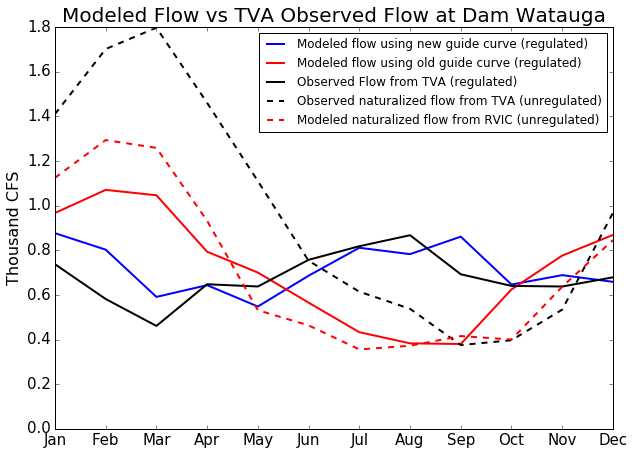

In [87]:
plt.figure(figsize=[10,7.2])
f1, = plt.plot(np.arange(1,13,1),L.streamflow/1000,'b-',label='Modeled flow using new guide curve (regulated)',linewidth=2)
f3, = plt.plot(np.arange(1,13,1),L_original.streamflow/1000,'r-',label='Modeled flow using old guide curve (regulated)',linewidth=2)
#f2, = plt.plot(np.arange(1,13,1),M.drop(M.columns[[0,1,2,3,4,5,-1,-2,-3,-4]],axis=1).mean(axis=1)/1000,'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
f2, = plt.plot(np.arange(1,13,1),M.drop(M.columns[[0,-1]],axis=1).mean(axis=1)/1000,'k-',label='Observed Flow from TVA (regulated)',linewidth=2)
f4, = plt.plot(np.arange(1,13,1),Natual_flow_TVA/1000,'k--',label='Observed naturalized flow from TVA (unregulated)',linewidth=2)
f5, = plt.plot(np.arange(1,13,1),Q.streamflow*np.power(3.28,3)/1000,'r--',label='Modeled naturalized flow from RVIC (unregulated)',linewidth=2)
plt.legend(handles = [f1,f3,f2,f4,f5])
title_name = 'Modeled Flow vs TVA Observed Flow at Dam '+Dam_info['dam_name'][i]
plt.title(title_name,fontsize=20)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Thousand CFS',fontsize=16)
plt.xticks(np.arange(1,13,1),('Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec'))
plt.xlim(1,12)
plt.ylim(0,)
output_path = '/raid/yifan/Reservoir_modeling/Analysis/fig_comparison_modeled_observed/Dam_'+Dam_info['dam_name'][i]+'_modeled_flow_vs_TVA_observed_flow'
plt.savefig(output_path,dpi=300)

In [91]:
Dam_info

,dam_number,dam_name,xls_name,output_name,dam_lat,dam_lon,grid_lat,grid_lon,year_operated_start_of_Calendar_year,top_vol_acre_feet,bot_vol_acre_feet,max_flow_cfs,min_flow_cfs
0,1,Watauga,watauga,Watauga,36.3233,-82.1219,36.3125,-82.0625,1949,677000,0,1132.7,107
1,2,South Holston,southholston,South_Holston,36.5233,-82.0889,36.5625,-82.0625,1951,764000,0,1246.0,90
2,3,Boone,boone,Boone,36.4400,-82.4378,36.4375,-82.4375,1953,193400,0,3998.4,400
3,5,Cherokee,cherokee,Cherokee,36.1661,-83.4983,36.1875,-83.4375,1942,1541000,0,7328.4,325
4,7,Douglas,douglas,Douglas,35.9611,-83.5389,35.9375,-83.4375,1943,1461000,0,11029.2,585
5,8,Fort Loudoun,fortloudoun,Fort_Loudoun,35.7909,-84.2427,35.8125,-84.1875,1943,393000,0,22085.9,710
6,11,Fontana,fontana,Fontana,35.4522,-83.8047,35.4375,-83.8125,1945,1443000,0,6151.8,790
7,16,Tellico,tellico,Tellico,35.7778,-84.2597,35.6875,-84.3125,1980,424000,0,8983.3,1000
8,17,Norris,norris,Norris,36.2242,-84.0914,36.1875,-84.0625,1936,2552000,0,6867.0,200
9,18,Watts Bar,wattsbar,Watts_Bar,35.6213,-84.7816,35.5625,-84.8125,1942,1175000,0,44998.9,1200
